In [2]:
# Prediction Candidates
# 2010 - 2011 Flu Season
# HHS Regions 5 and 9
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import numpy as np
from sklearn.metrics import mean_squared_error

%matplotlib inline

plt.style.use('ggplot')
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
    (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
    (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
    (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
    (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)


def weekTransform(row):
    if (row["WEEK"] >= 40):
        week = row["WEEK"] - 40
    else:
        week = row["WEEK"] + 12
    return(week)

data = pd.read_csv('WHO_NREVSS_Combined_2010_2011-HHS.csv', header=1)
data['T'] = data.apply(weekTransform, axis=1)
data = data.drop(["REGION TYPE"], axis=1)

data['TOTAL'] = data['A (H3)'] + data['A (Subtyping not Performed)']

dataHHS5 = data[data['REGION'] == 'Region 5']
dataHHS9 = data[data['REGION'] == 'Region 9']

X = dataHHS5['T']

Y = dataHHS5['A (H3)']
Y2 = dataHHS9['A (H3)']

Y3 = dataHHS5['A (Subtyping not Performed)']
Y4 = dataHHS9['A (Subtyping not Performed)']

Y5 = dataHHS5['TOTAL']
Y6 = dataHHS9['TOTAL']

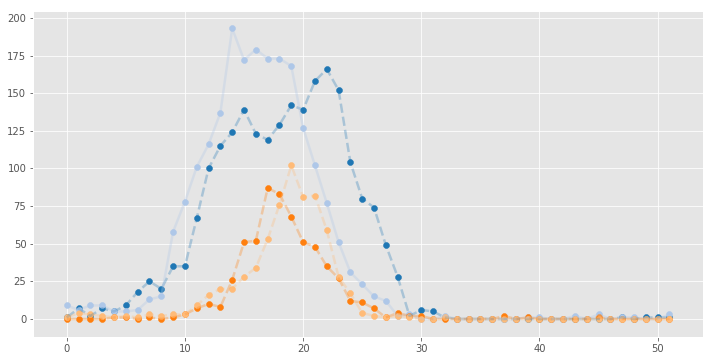

In [3]:
plt.figure(figsize=(12,6))
plt.plot(X, Y, ls="--", lw=2.5, color=tableau20[0], alpha=0.3)
plt.scatter(X, Y, color=tableau20[0])
plt.plot(X, Y2, lw=2.5, color=tableau20[1], alpha=0.3)
plt.scatter(X, Y2, color=tableau20[1])

plt.plot(X, Y3, ls="--", lw=2.5, color=tableau20[2], alpha=0.3)
plt.scatter(X, Y3, color=tableau20[2])
plt.plot(X, Y4, ls="--", lw=2.5, color=tableau20[3], alpha=0.3)
plt.scatter(X, Y4, color=tableau20[3])

#plt.plot(X, Y5, ls="--", lw=2.5, color=tableau20[4], alpha=0.3)
#plt.scatter(X, Y5, color=tableau20[4])
#plt.plot(X, Y6, ls="--", lw=2.5, color=tableau20[5], alpha=0.3)
#plt.scatter(X, Y6, color=tableau20[5])

In [4]:
dfStatePop = pd.read_csv("population.csv")
dfStatePop.columns = ['State', 'Population']
dfStatePop['Population'] = dfStatePop['Population'].apply(lambda x: int(x))
dfStatePop['State'] = dfStatePop['State'].apply(lambda x: x.strip())
statePop = dfStatePop.set_index('State').to_dict()['Population']
HHS5 = statePop['Minnesota'] + statePop['Wisconsin'] + statePop['Illinois'] + statePop['Indiana'] \
        + statePop['Michigan'] + statePop['Ohio']
HHS9 = statePop['California'] + statePop['Nevada'] + statePop['Arizona'] + statePop['Hawaii']

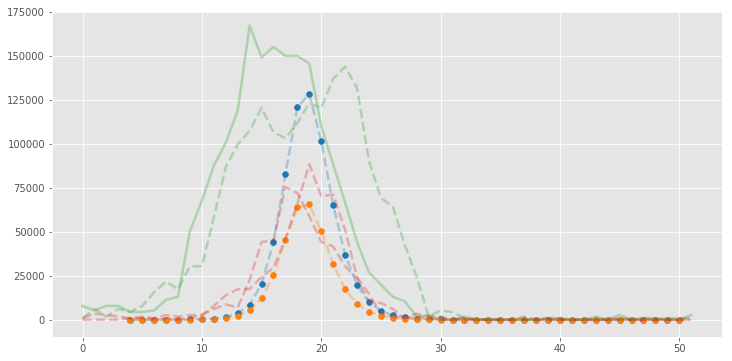

In [13]:
N = HHS5 * 0.09
IA0 = 1
IB0 = 1
R0 = 0
S0 = N - R0 - IA0 - IB0

gamma = 1.0/3
rhoA = 1.39
rhoB = 1.37
betaA = rhoA*gamma
betaB = rhoB*gamma

def deriv(y, t, N, betaA, betaB, gamma):
    S, IA, IB, R = y
    dSdt = -betaA * S * IA / N + -betaB * S * IB / N
    dIAdt = betaA * S * IA / N - gamma * IA
    dIBdt = betaB * S * IB / N - gamma * IB
    dRdt = gamma * IA + gamma * IB
    return dSdt, dIAdt, dIBdt, dRdt

y0 = S0, IA0, IB0, R0

minT = 4
maxT = 51
t = list(range(minT*7, maxT*7))
w = range(minT, maxT)

ret = odeint(deriv, y0, t, args=(N, betaA, betaB, gamma))
S, IA, IB, R = ret.T

pY1HHS5 = IA[0:len(IA)-1:7]#-np.diff(S[0:len(S)-1:7])
pY2HHS5 = IB[0:len(IB)-1:7]#-np.diff(S[0:len(S)-1:7])

plt.figure(figsize=(12,6))
plt.plot(w, pY1HHS5, ls="--", lw=2.5, color=tableau20[0], alpha=0.3)
plt.scatter(w, pY1HHS5, color=tableau20[0])
plt.plot(w, pY2HHS5, ls="--", lw=2.5, color=tableau20[2], alpha=0.3)
plt.scatter(w, pY2HHS5, color=tableau20[2])
plt.plot(X, Y*78/0.09, ls="--", lw=2.5, color=tableau20[4], alpha=0.3)
plt.plot(X, Y2*78/0.09, lw=2.5, color=tableau20[4], alpha=0.3)
plt.plot(X, Y3*78/0.09, ls="--", lw=2.5, color=tableau20[6], alpha=0.3)
plt.plot(X, Y4*78/0.09, ls="--", lw=2.5, color=tableau20[6], alpha=0.3)

In [15]:
outputDF = pd.DataFrame(np.column_stack((X, Y*78/0.09, Y2*78/0.09, Y3*78/0.09, Y4*78/0.09)), columns=['T', 'A (H3) : HHS5', 'A (H3) : HHS9', 'A (Subtyping not Performed) : HHS5', 'A (Subtyping not Performed) : HHS9'])

#outputDF.to_csv('data-transform.csv')

,T,A (H3) : HHS5,A (H3) : HHS9,A (Subtyping not Performed) : HHS5,A (Subtyping not Performed) : HHS9
0,0.0,866.666667,7800.000000,0.000000,866.666667
1,1.0,6066.666667,5200.000000,0.000000,3466.666667
2,2.0,1733.333333,7800.000000,0.000000,2600.000000
3,3.0,6066.666667,7800.000000,0.000000,1733.333333
4,4.0,4333.333333,4333.333333,866.666667,866.666667
5,5.0,7800.000000,4333.333333,866.666667,1733.333333
6,6.0,15600.000000,5200.000000,0.000000,866.666667
7,7.0,21666.666667,11266.666667,866.666667,2600.000000
8,8.0,17333.333333,13000.000000,0.000000,1733.333333
9,9.0,30333.333333,50266.666667,866.666667,2600.000000
